In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data, prep_fa_dataset, prep_fa_flattned_data, kl_divergence_loss, vae_loss
from afqinsight.nn.utils import prep_fa_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug
from afqinsight.nn.pt_models import Conv1DVariationalAutoencoder
from afqinsight.nn.utils import reconstruction_loss
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# FA FLATTENED DATASET
# NON VARIATIONAL 
# CONVOLUTIONAL AUTOENCODER
# TESTING LATENT AND DROPOUT SIMULTATENTOUSLY 

In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)
# print()

# #Additional Info when using cuda
# if device.type == 'cuda':
#     print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

device = 'mps'

In [4]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [5]:
torch_dataset, all_tracts_train_loader, all_tracts_test_loader, all_tracts_val_loader = prep_fa_flattned_data(dataset,batch_size=64)

In [6]:
class Conv1DEncoder_one_tract_fa(nn.Module):
    def __init__(self, latent_dims=20, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)
        
        # Instead of directly mapping to latent space, we'll produce two outputs:
        # mean and log variance (each of size latent_dims)
        # self.conv4_mean = nn.Conv1d(64, latent_dims, kernel_size=5, stride=2, padding=2)
        # self.conv4_logvar = nn.Conv1d(64, latent_dims, kernel_size=5, stride=2, padding=2)

        self.fc_mean = nn.Linear(64*7, latent_dims)
        self.fc_logvar = nn.Linear(64*7, latent_dims)
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x = torch.flatten(x, 1)
        x = F.relu(self.conv1(x)) # [64, 16, 25]
        x = self.dropout(x)
        x = F.relu(self.conv2(x)) # [64, 32, 13]
        x = self.dropout(x)
        x = F.relu(self.conv3(x)) # [64, 64, 7]
        x = self.dropout(x)
        
        # mean = self.conv4_mean(x)
        # logvar = self.conv4_logvar(x)
        x = self.flatten(x) # [64, 64*7]
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)    
        

        return mean, logvar

class Conv1DDecoder_one_tract_fa(nn.Module):
    def __init__(self, latent_dims=20):
        super().__init__()
        self.fc = nn.Linear(latent_dims, 64 * 7)
        # self.deconv1 = nn.ConvTranspose1d(latent_dims, 64, kernel_size=5, stride=2, padding=2, output_padding=0)
        self.deconv2 = nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=0)
        self.deconv3 = nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=2, output_padding=1)
        self.deconv4 = nn.ConvTranspose1d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        batch_size = x.size(0)
        x = self.fc(x)
        x = x.view(batch_size, 64, 7)
        # x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = self.deconv4(x)
        return x
        # return x.view(batch_size, -1)

class Conv1DVariationalAutoencoder_one_tract_fa(nn.Module):
    def __init__(self, latent_dims=20, dropout=0.0):
        super().__init__()
        self.encoder = Conv1DEncoder_one_tract_fa(latent_dims, dropout=dropout)
        self.decoder = Conv1DDecoder_one_tract_fa(latent_dims)
        self.latent_dims = latent_dims
        
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z
    
    def forward(self, x):
        mean, logvar = self.encoder(x)
        
        z = self.reparameterize(mean, logvar)
        
        x_prime = self.decoder(z)
        
        return x_prime, mean, logvar

In [31]:
def train_variational_autoencoder_widescope(model, train_data, val_data, epochs=500, lr=0.001, kl_weight=0.001):
    """
    Training loop for variational autoencoder with KL annealing
    """
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    
    train_rmse_per_epoch = []
    val_rmse_per_epoch = []
    train_kl_per_epoch = []
    val_kl_per_epoch = []
    train_recon_per_epoch = []
    val_recon_per_epoch = []
    
    best_val_rmse = float('inf')  # Track the best (lowest) validation RMSE
    best_model_state = None  # Save the best model state

    #lets try KL annealing
    beta_start = 0.0
    beta_end = 1.0
    slope = (beta_end - beta_start) / epochs
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0
        running_rmse = 0
        running_kl = 0
        items = 0
        running_recon_loss = 0 
        beta = beta_start + slope * epoch
        
        for x, _ in train_data:
            batch_size = x.size(0)
            tract_data = x.to(device)  # Shape: (batch_size, 100)
            
            opt.zero_grad()
            
            # Forward pass returns reconstructed x, mean and logvar
            x_hat, mean, logvar = model(tract_data)
            
            # Compute loss with KL divergence
            loss, recon_loss, kl_loss = vae_loss(tract_data, x_hat, mean, logvar, beta, reduction="sum")
            #recon loss here is the sum of the MSE
            #loss is the sum of the KL and the recon loss
            #kl loss is the sum of the KL
            #none are normalized yet 

            # Calculate RMSE (primarily for logging)
            batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))
            
            loss.backward()
            opt.step()
              
            #increasing by batch size
            items += batch_size
            running_loss += loss.item()
            running_rmse += batch_rmse.item() * batch_size  # Weighted sum
            running_kl += kl_loss.item() # Average KL per item
            running_recon_loss += recon_loss.item() # Average recon loss per item
        
        scheduler.step(running_loss / items)
        avg_train_rmse = running_rmse / items
        avg_train_kl = running_kl / items 
        avg_train_recon_loss = running_recon_loss / items
        train_rmse_per_epoch.append(avg_train_rmse)
        train_kl_per_epoch.append(avg_train_kl)
        train_recon_per_epoch.append(avg_train_recon_loss)

        # Validation
        model.eval()
        val_rmse = 0
        val_kl = 0
        val_items = 0
        val_recon_loss = 0
        
        with torch.no_grad():
            for x, *_ in val_data:
                batch_size = x.size(0)
                tract_data = x.to(device)
                
                x_hat, mean, logvar = model(tract_data)
                
                val_loss, val_recon_loss, val_kl_loss = vae_loss(tract_data, x_hat, mean, logvar, beta, reduction="sum")
                
                batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                val_items += batch_size
                val_loss += val_loss.item()
                val_rmse += batch_val_rmse.item() * tract_data.size(0)
                val_kl += val_kl_loss.item()
                val_recon_loss += val_recon_loss.item()
        
        avg_val_recon_loss = val_recon_loss / val_items
        avg_val_rmse = val_rmse / val_items
        avg_val_kl = val_kl / val_items
        val_rmse_per_epoch.append(avg_val_rmse)
        val_kl_per_epoch.append(avg_val_kl)
        val_recon_per_epoch.append(avg_val_recon_loss)
        
        # Check and save the best model state if current validation loss is lower
        if avg_val_rmse < best_val_rmse:
            print("Saving best model state with RMSE:", avg_val_rmse)
            best_val_rmse = avg_val_rmse
            best_model_state = model.state_dict().copy()  # Make a copy to ensure it's preserved
        
        print(f"Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}, KL: {avg_train_kl:.4f}," ,
              f"Recon Loss (Train): {avg_train_recon_loss:.4f}, Recon Loss (Val): {avg_val_recon_loss:.4f}")
    
    # Load the best model state back into the model
    model.load_state_dict(best_model_state)
    
    return {
        "train_rmse_per_epoch": train_rmse_per_epoch,
        "val_rmse_per_epoch": val_rmse_per_epoch,
        "train_kl_per_epoch": train_kl_per_epoch,
        "val_kl_per_epoch": val_kl_per_epoch,
        "train_recon_per_epoch": train_recon_per_epoch,
        "val_recon_per_epoch": val_recon_per_epoch,
        "best_val_rmse": best_val_rmse,
    }

In [32]:
latent_dims = [2, 4, 8, 16, 32, 64, 100]
dropout_values = [0.0, 0.1, 0.5]
models = {}
results = {}

for dropout in dropout_values:
    for latent_dim in latent_dims:
        print(f"Training Autoencoder with Latent Dimension: {latent_dim} and Dropout: {dropout}")
        
        # Initialize a new autoencoder for each latent dimension
        test_model = Conv1DVariationalAutoencoder_one_tract_fa(latent_dims=latent_dim, dropout=dropout).to(device)
        
        # Train the model 
        training_results = train_variational_autoencoder_widescope(test_model, all_tracts_train_loader, all_tracts_val_loader, 100, 0.001)
        
        # Store both the model and results
        models[latent_dim, dropout] = test_model
        results[latent_dim, dropout] = training_results
        
        print(f"Completed training for latent_dim={latent_dim}, Best Val RMSE: {training_results['best_val_rmse']:.4f}")


Training Autoencoder with Latent Dimension: 2 and Dropout: 0.0
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
torch.Size([64, 1, 50])
t

KeyboardInterrupt: 

AttributeError: 'tuple' object has no attribute 'cpu'

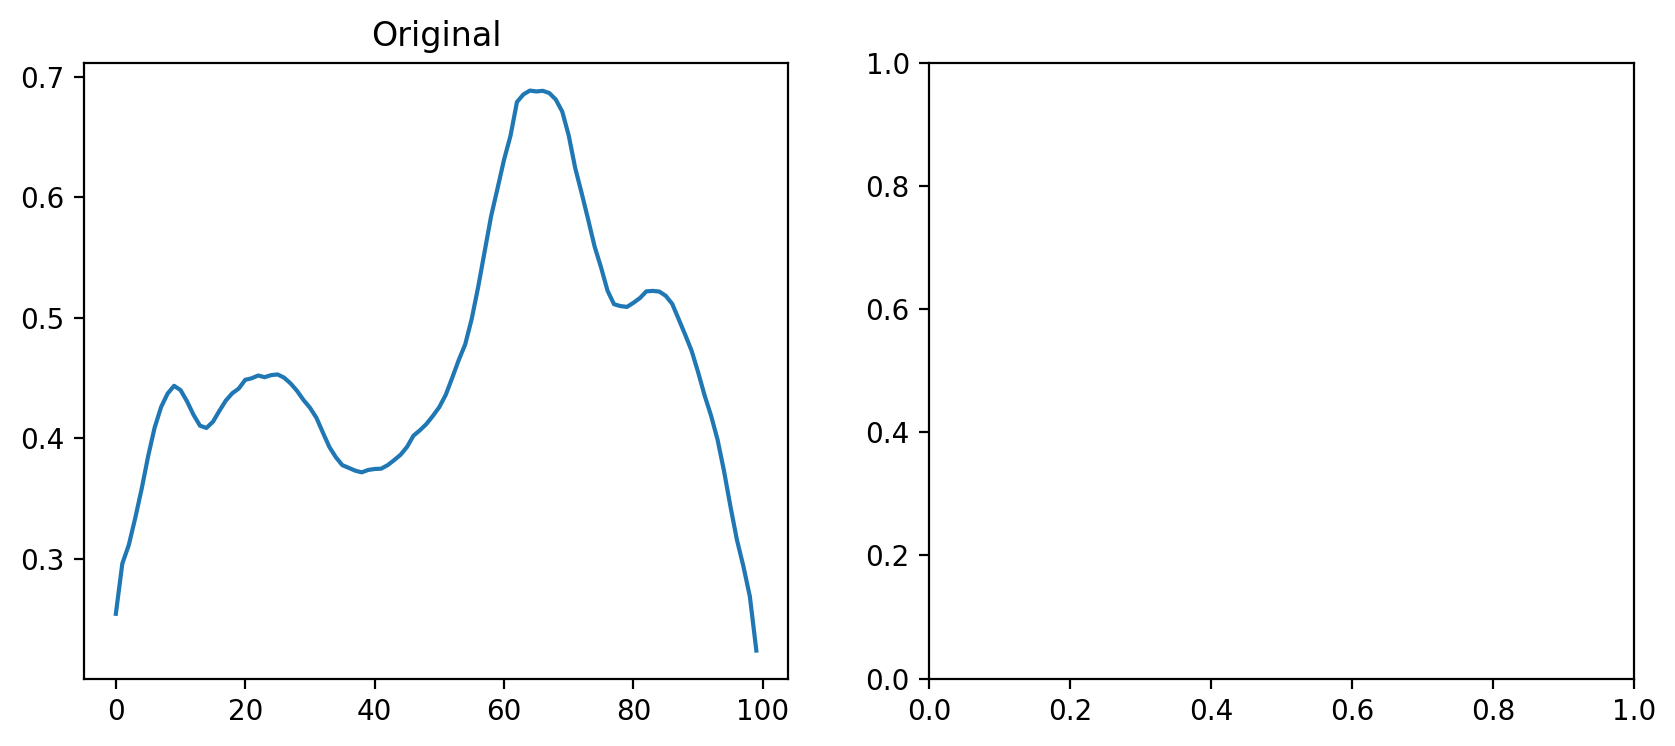

In [ ]:
model_with_latent_8 = models[8, 0.1]

# Visualize a reconstruction
def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        # Get a batch of data
        for x, _ in data_loader:
            # Take just one sample for visualization
            sample = x[0:1, 0:1, :].to(device)
            reconstruction = model(sample)
            
            # Plot the original and reconstruction
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.plot(sample.cpu().numpy()[0, 0, :])
            plt.title("Original")
            
            plt.subplot(1, 2, 2)
            plt.plot(reconstruction.cpu().numpy()[0, 0, :])
            plt.title("Reconstruction")
            
            plt.tight_layout()
            plt.show()
            break

# Visualize a reconstruction from a model with latent dimension 8
# for latent_dim in latent_dims:
visualize_reconstruction(models[8, 0.1], val_loader)

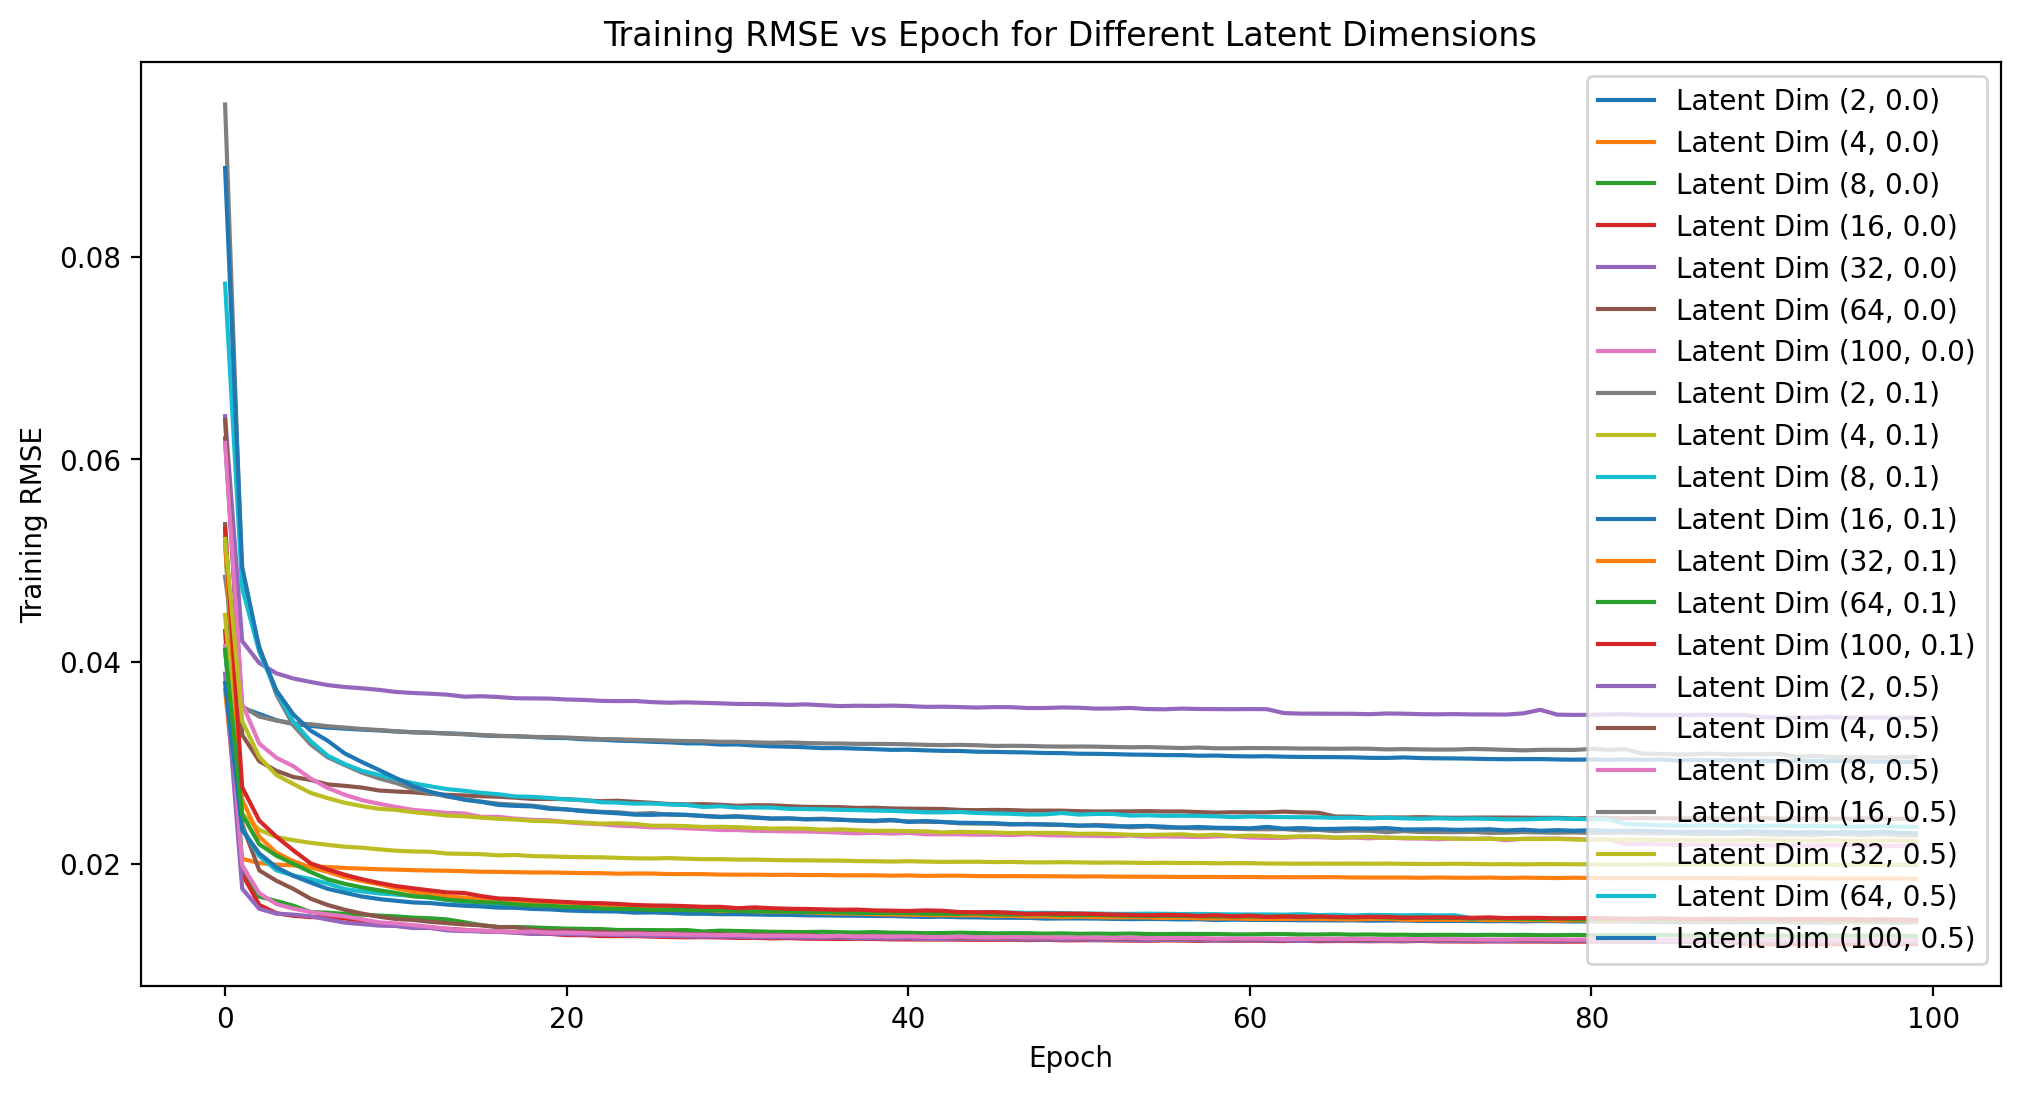

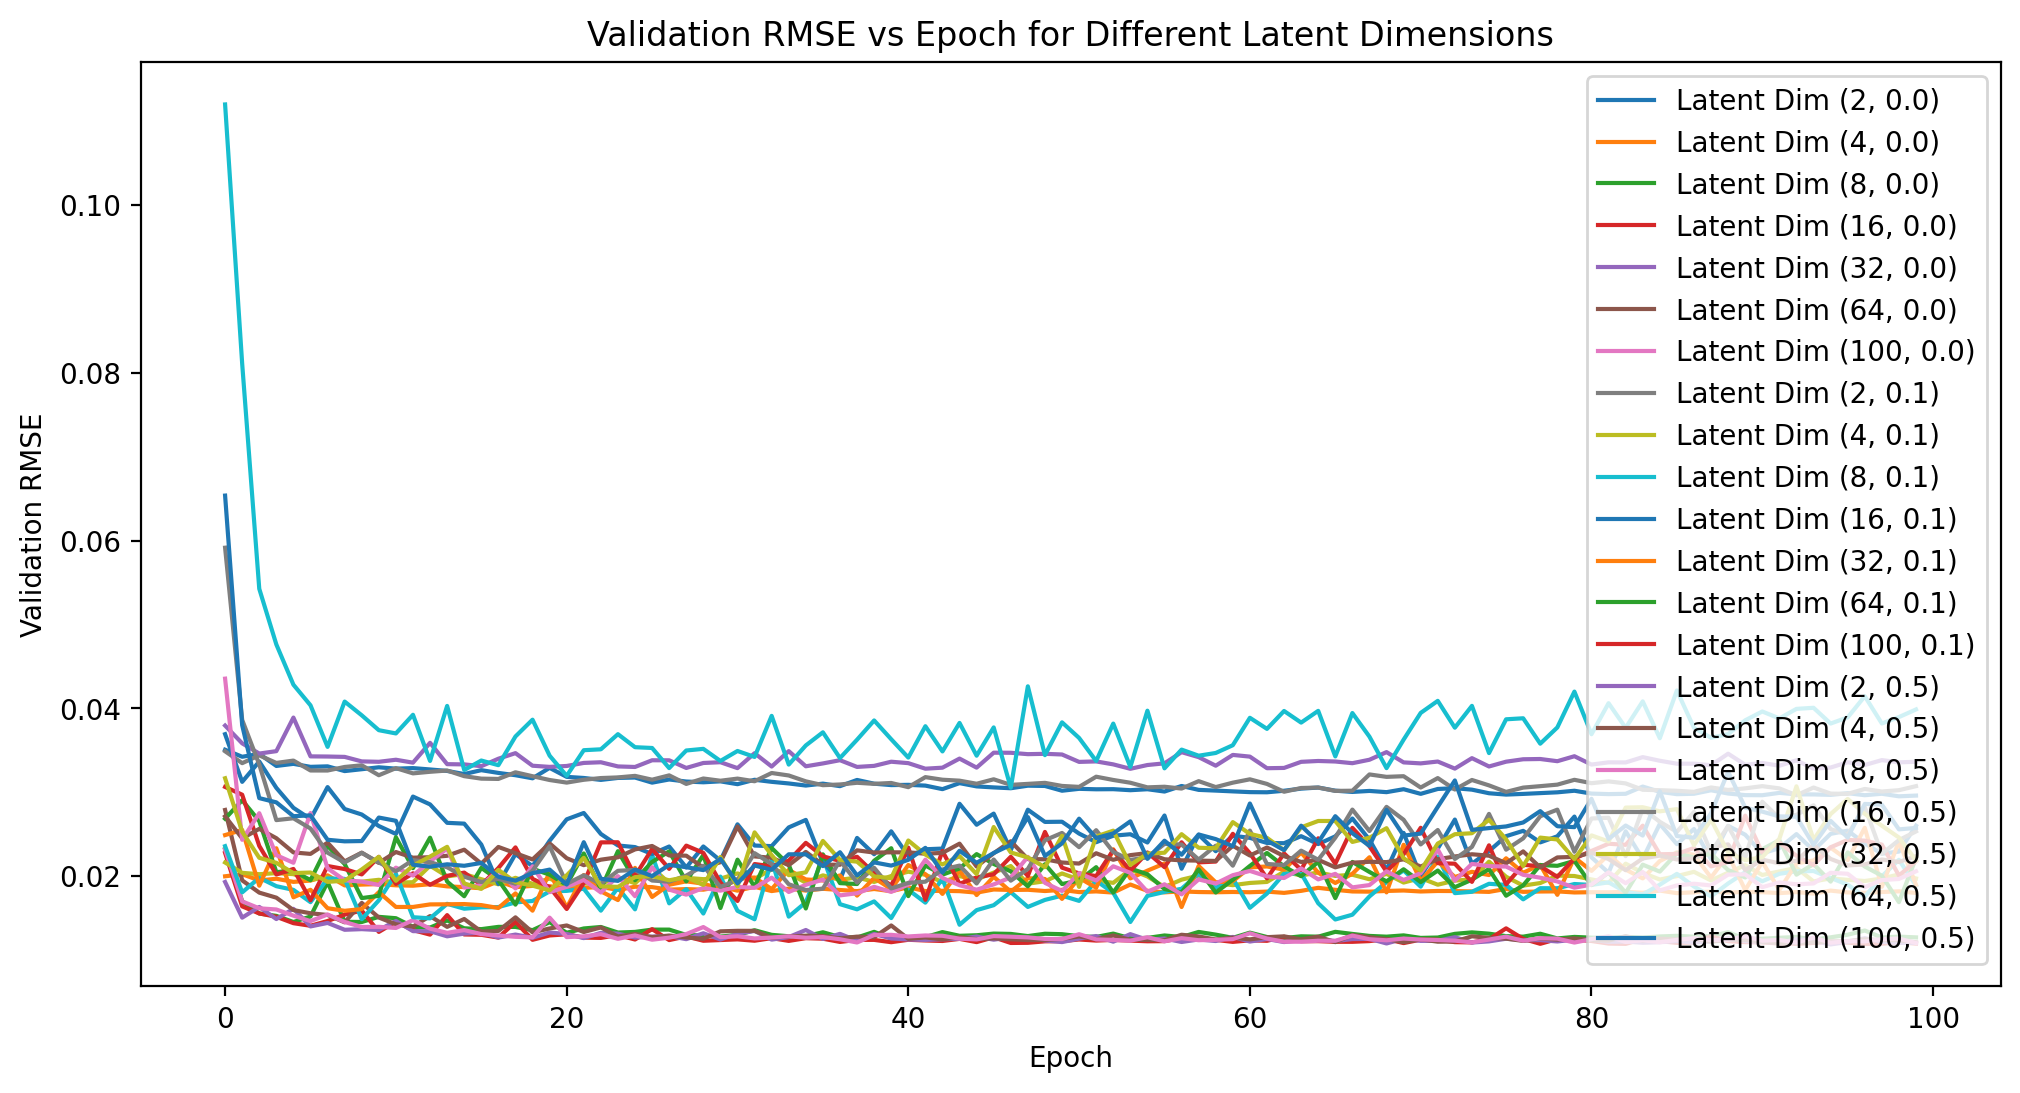

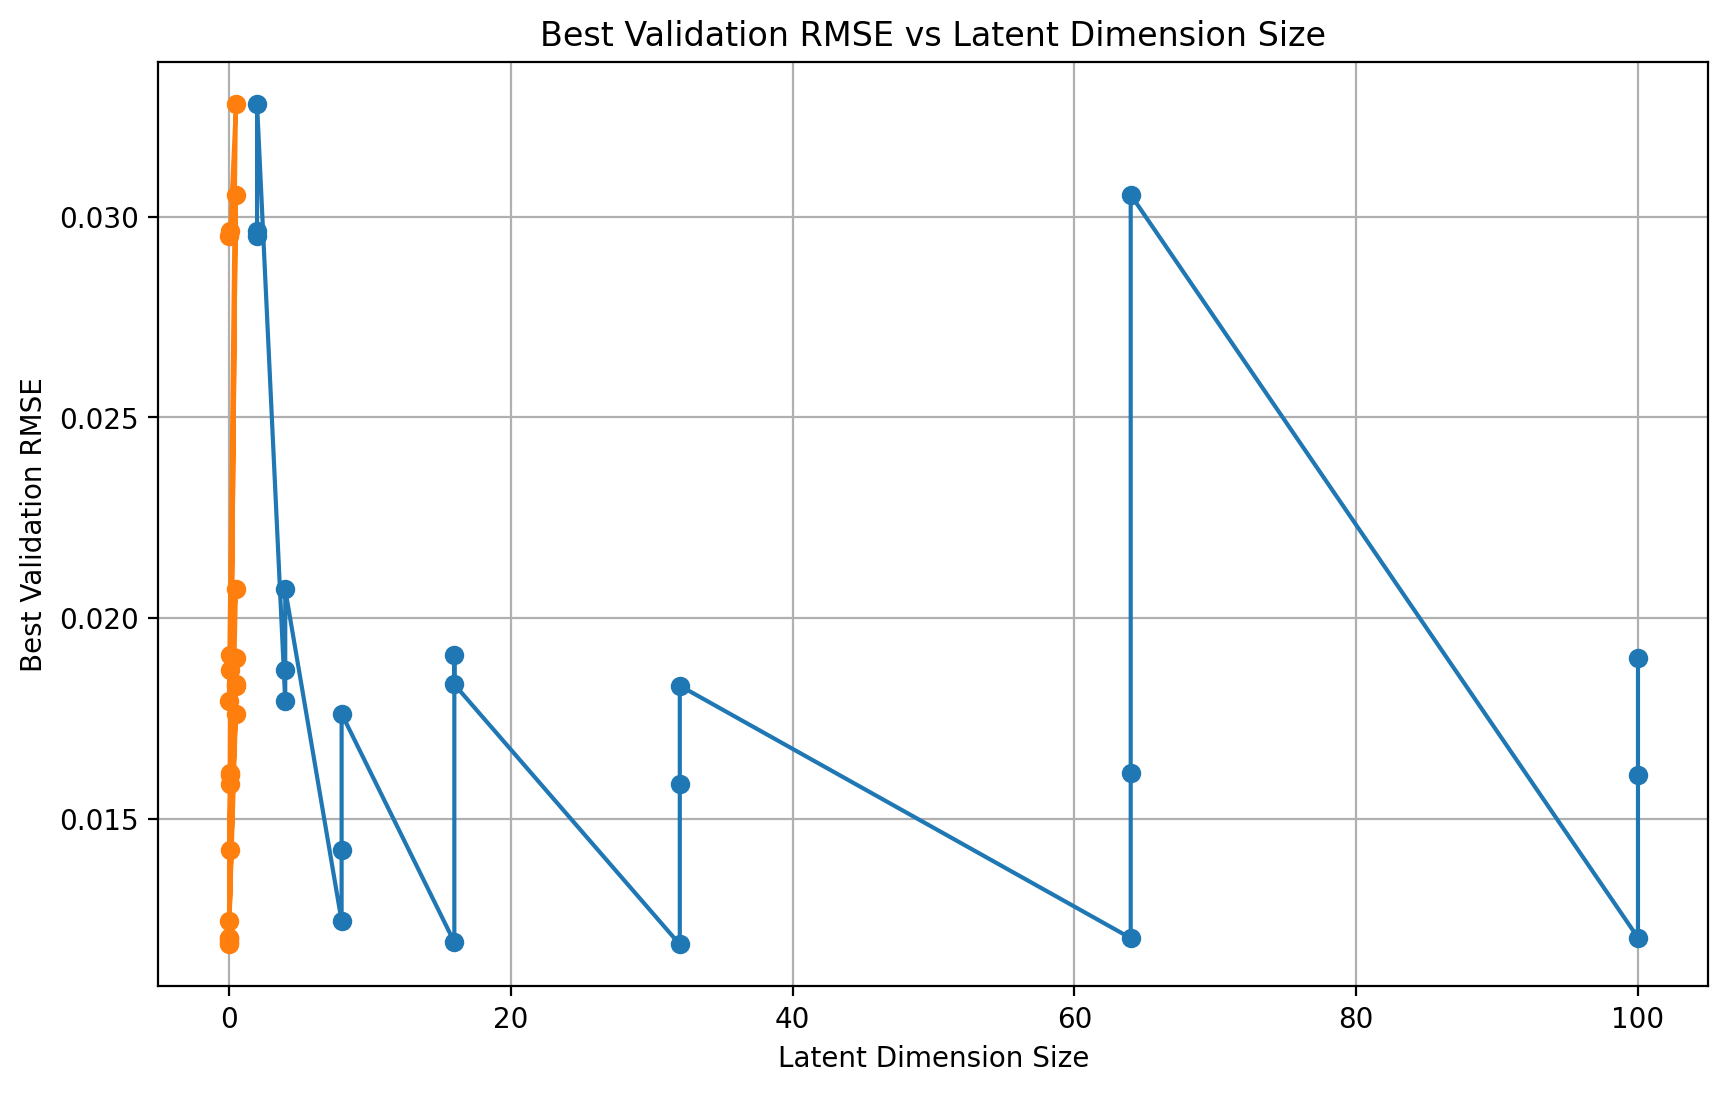

In [ ]:
# Plot training RMSE vs epoch for each latent dimension
plt.figure(figsize=(12, 6))
for dim in models.keys():
    plt.plot(results[dim]["train_rmse_per_epoch"], label=f"Latent Dim {dim}")
plt.xlabel("Epoch")
plt.ylabel("Training RMSE")
plt.legend()
plt.title("Training RMSE vs Epoch for Different Latent Dimensions")
plt.show()

# Plot validation RMSE vs epoch for each latent dimension
plt.figure(figsize=(12, 6))
for dim in models.keys():
    plt.plot(results[dim]["val_rmse_per_epoch"], label=f"Latent Dim {dim}")
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.legend()
plt.title("Validation RMSE vs Epoch for Different Latent Dimensions")
plt.show()

# Plot best validation loss for each latent dimension
latent_dims = sorted(list(models.keys()))  # Get sorted list of latent dimensions
best_val_losses = [results[dim]["best_val_loss"] for dim in latent_dims]

plt.figure(figsize=(10, 6))
plt.plot(latent_dims, best_val_losses, 'o-')
plt.xlabel("Latent Dimension Size")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs Latent Dimension Size")
plt.grid(True)
plt.show()

In [ ]:
print(results.keys())
print(latent_dims[0][0])

dict_keys([(2, 0.0), (4, 0.0), (8, 0.0), (16, 0.0), (32, 0.0), (64, 0.0), (100, 0.0), (2, 0.1), (4, 0.1), (8, 0.1), (16, 0.1), (32, 0.1), (64, 0.1), (100, 0.1), (2, 0.5), (4, 0.5), (8, 0.5), (16, 0.5), (32, 0.5), (64, 0.5), (100, 0.5)])
2


Latent Dim: 2, Dropout: 0.0
Latent Dim: 2, Dropout: 0.1
Latent Dim: 2, Dropout: 0.5
Latent Dim: 4, Dropout: 0.0
Latent Dim: 4, Dropout: 0.1
Latent Dim: 4, Dropout: 0.5
Latent Dim: 8, Dropout: 0.0
Latent Dim: 8, Dropout: 0.1
Latent Dim: 8, Dropout: 0.5
Latent Dim: 16, Dropout: 0.0
Latent Dim: 16, Dropout: 0.1
Latent Dim: 16, Dropout: 0.5
Latent Dim: 32, Dropout: 0.0
Latent Dim: 32, Dropout: 0.1
Latent Dim: 32, Dropout: 0.5
Latent Dim: 64, Dropout: 0.0
Latent Dim: 64, Dropout: 0.1
Latent Dim: 64, Dropout: 0.5
Latent Dim: 100, Dropout: 0.0
Latent Dim: 100, Dropout: 0.1
Latent Dim: 100, Dropout: 0.5


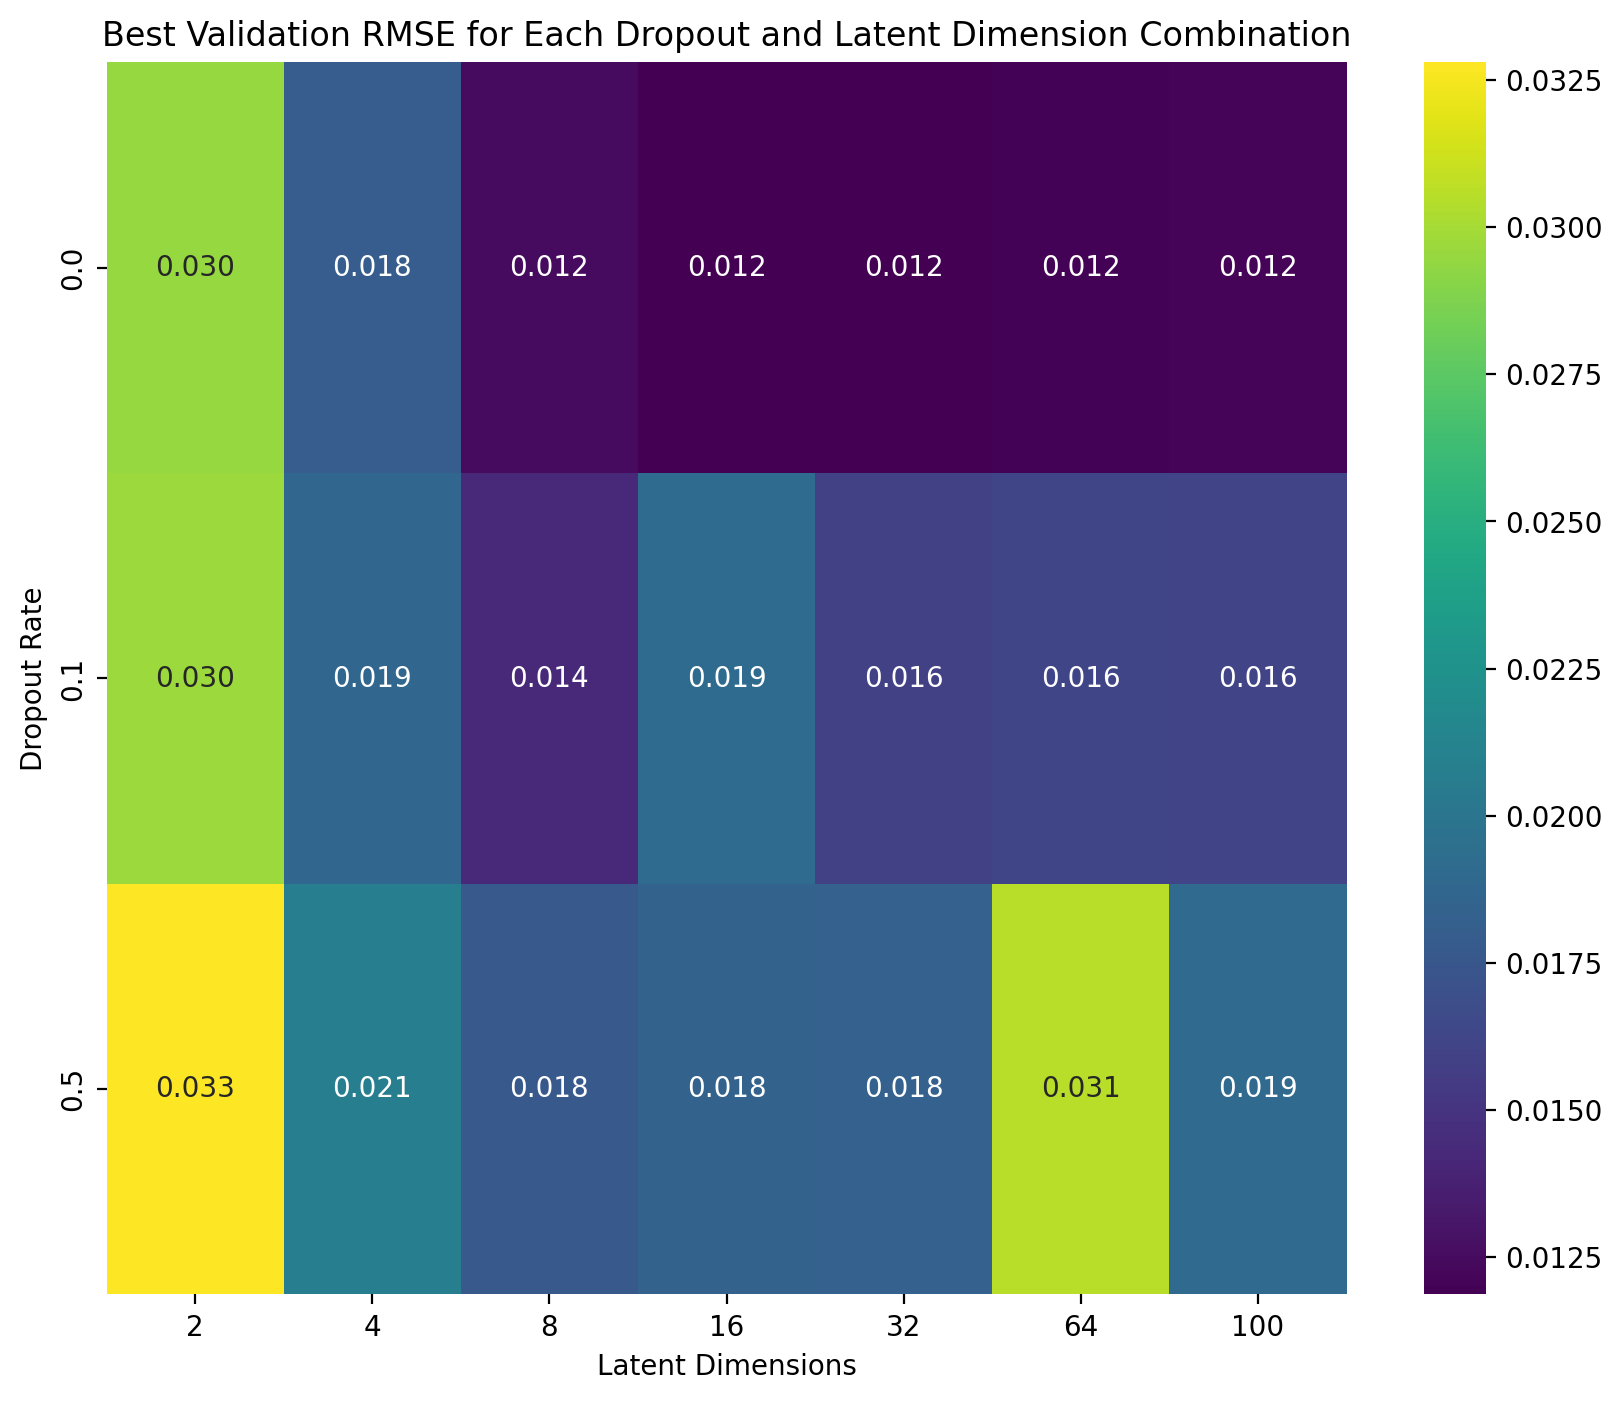

In [ ]:
# Create a DataFrame with rows for dropout and columns for latent_dims
latent_dims = [2, 4, 8, 16, 32, 64, 100]
dropout_values = [0.0, 0.1, 0.5]
df_best_val = pd.DataFrame(index=dropout_values, columns=latent_dims)

# Populate the DataFrame with the best validation RMSE values
for latent_dim in latent_dims:
    for dropout in dropout_values:
        print(f"Latent Dim: {latent_dim}, Dropout: {dropout}")  
        key = (latent_dim, dropout)
        if key in results:
            best_val_loss = results[key]["best_val_rmse"]
            df_best_val.loc[dropout, latent_dim] = best_val_loss
        else:
            print(f"Key {key} not found in results.")
            # Handle missing key, e.g., set a default value
            df_best_val.loc[dropout, latent_dim] = np.nan  # or any other default


# Convert the values to floats (if they aren't already)
df_best_val = df_best_val.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_best_val, annot=True, fmt=".3f", cmap="viridis")
plt.xlabel("Latent Dimensions")
plt.ylabel("Dropout Rate")
plt.title("Best Validation RMSE for Each Dropout and Latent Dimension Combination")
plt.show()
